In [14]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- CONFIGURARE STIL ---
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

HOUSES = ['House1', 'House2']
print("Biblioteci incarcate. Stil configurat.")

Biblioteci incarcate. Stil configurat.


In [15]:
results_data = []

print("Incarcare rezultate...", end=" ")

for house in HOUSES:
    filename = f'results_{house}.pkl'
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            
        y_true = data['y_true']
        preds = data['rezultate']
        times = data['timpi']
        
        for model_name, y_pred in preds.items():
            # Asiguram ca dimensiunile coincid
            if len(y_pred) != len(y_true):
                min_len = min(len(y_pred), len(y_true))
                y_pred = y_pred[:min_len]
                y_true_cut = y_true[:min_len]
            else:
                y_true_cut = y_true
                
            # Calcul Metrici
            mae = mean_absolute_error(y_true_cut, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true_cut, y_pred))
            time_sec = times.get(model_name, 0)
            
            results_data.append({
                'Casa': house,
                'Model': model_name,
                'MAE (W)': mae,
                'RMSE': rmse,
                'Timp (s)': time_sec
            })
            
    except FileNotFoundError:
        print(f"\n[ATENTIE] Fisierul {filename} lipseste! Asigura-te ca ai rulat Notebook-ul 2.")

# Creare DataFrame
df_results = pd.DataFrame(results_data)
print("GATA!")


Incarcare rezultate... GATA!


In [16]:
# Sortam dupa Performanta Generala (Media MAE intre case)
order = df_results.groupby('Model')['MAE (W)'].mean().sort_values().index

print("\n" + "="*80)
print(f"=== CLASAMENT FINAL DETALIAT (Sortat dupa MAE) ===")
print("="*80)

# Formatare tabel pentru printare ca in poza ta
print(f"{'CASA':<10} | {'MODEL':<12} | {'MAE (W)':<10} | {'RMSE':<10} | {'TIMP (s)':<10}")
print("-" * 65)

for house in HOUSES:
    df_house = df_results[df_results['Casa'] == house].sort_values('MAE (W)')
    for _, row in df_house.iterrows():
        print(f"{row['Casa']:<10} | {row['Model']:<12} | {row['MAE (W)']:<10.2f} | {row['RMSE']:<10.2f} | {row['Timp (s)']:<10.1f}")
    print("-" * 65)




=== CLASAMENT FINAL DETALIAT (Sortat dupa MAE) ===
CASA       | MODEL        | MAE (W)    | RMSE       | TIMP (s)  
-----------------------------------------------------------------
House1     | XGBoost      | 52.79      | 224.69     | 8.6       
House1     | LightGBM     | 52.89      | 223.45     | 4.3       
House1     | GRU          | 62.06      | 305.45     | 4321.7    
House1     | DeepAR       | 80.17      | 326.23     | 3648.6    
House1     | RNN          | 89.12      | 338.04     | 387.1     
House1     | LSTM         | 107.63     | 308.65     | 3818.2    
House1     | Prophet      | 438.45     | 535.55     | 488.3     
-----------------------------------------------------------------
House2     | LightGBM     | 59.41      | 262.48     | 4.1       
House2     | XGBoost      | 62.78      | 274.87     | 6.1       
House2     | GRU          | 69.62      | 355.26     | 4142.7    
House2     | RNN          | 99.07      | 405.21     | 338.7     
House2     | DeepAR       | 102.89  

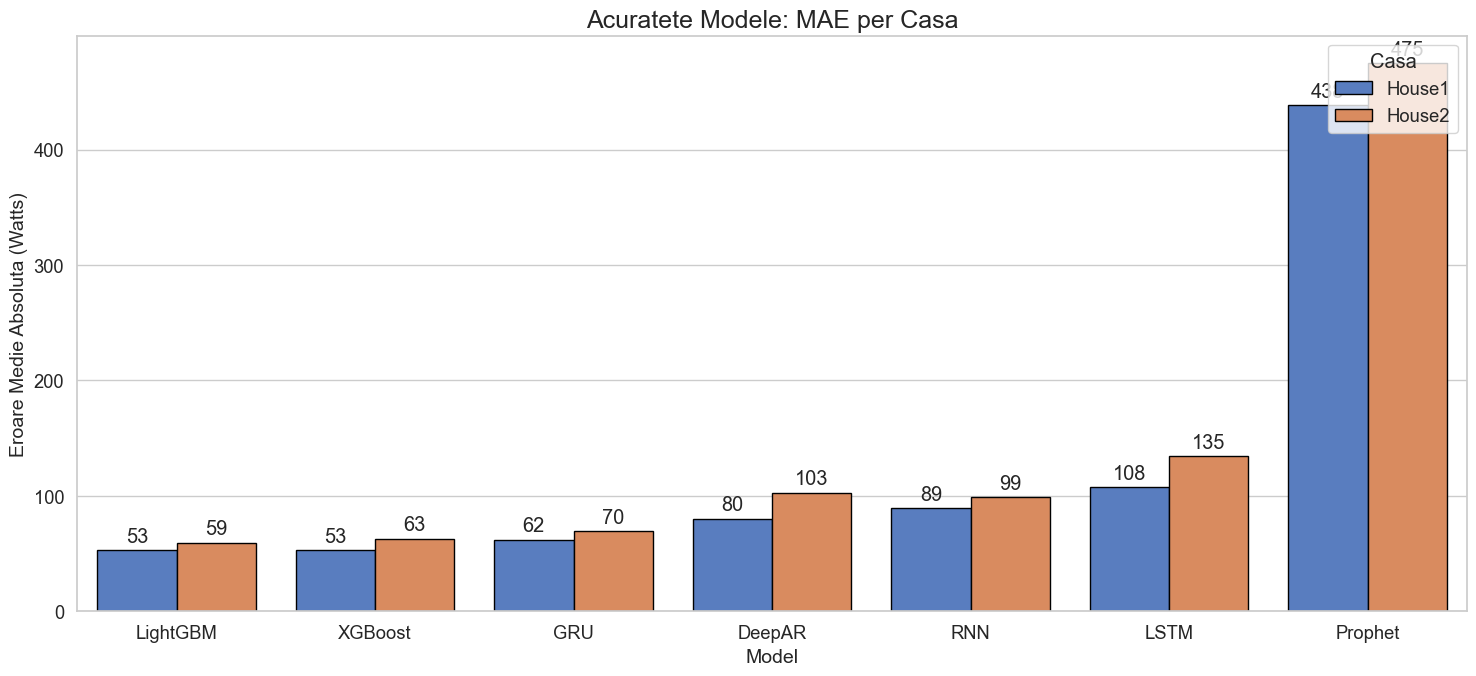

In [17]:
plt.figure(figsize=(15, 7))

# Barplot grupat
ax = sns.barplot(x='Model', y='MAE (W)', hue='Casa', data=df_results, 
                 order=order, palette='muted', edgecolor='black')

plt.title('Acuratete Modele: MAE per Casa', fontsize=18)
plt.ylabel('Eroare Medie Absoluta (Watts)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Casa', loc='upper right')

# Adaugam valori pe bare
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# 1. Incarcam datele reale pentru a afla MEDIA consumului
try:
    df1 = pd.read_csv('CLEAN_House1.csv')
    df2 = pd.read_csv('CLEAN_House2.csv')

    mean_h1 = df1['Aggregate'].mean()
    mean_h2 = df2['Aggregate'].mean()

except FileNotFoundError:
    print("Nu gasesc fisierele CSV! Asigura-te ca sunt in folder.")

# 2. Introducem valorile tale obtinute (Best Models)

# A. Pentru HOUSE 1
# 1. Filtram doar House1
best_h1 = df_results[df_results['Casa'] == 'House1'].sort_values(by='MAE (W)').iloc[0]
model_h1_name = best_h1['Model']
mae_h1 = best_h1['MAE (W)']
rmse_h1 = best_h1['RMSE']

# B. Pentru HOUSE 2 
# 2. Filtram doar House2
best_h2 = df_results[df_results['Casa'] == 'House2'].sort_values(by='MAE (W)').iloc[0]
model_h2_name = best_h2['Model']
mae_h2 = best_h2['MAE (W)']
rmse_h2 = best_h2['RMSE']

# 3. Calculam procentele
mae_perc_h1 = (mae_h1 / mean_h1) * 100
rmse_perc_h1 = (rmse_h1 / mean_h1) * 100

mae_perc_h2 = (mae_h2 / mean_h2) * 100
rmse_perc_h2 = (rmse_h2 / mean_h2) * 100

# 4. Afisare Raport 
print(f"=== RAPORT PROCENTUAL EROARE ===")

print(f"\n--- HOUSE 1 (Consum Mediu: {mean_h1:.2f} W) ---")
print(f"Model: XGBoost")
print(f"MAE Relativ:  {mae_perc_h1:.2f}%  <-- (Cat gresesti in medie)")
print(f"RMSE Relativ: {rmse_perc_h1:.2f}% <-- (Cat gresesti la varfuri/spikes)")

print(f"\n--- HOUSE 2 (Consum Mediu: {mean_h2:.2f} W) ---")
print(f"Model: LightGBM")
print(f"MAE Relativ:  {mae_perc_h2:.2f}%")
print(f"RMSE Relativ: {rmse_perc_h2:.2f}%")


print("\n=== INTERPRETARE REZULTATE ===")

# --- Interpretare House 1 ---
if mae_perc_h1 < 15:
    print("House 1: Performanta Ridicata (Sub 15%)")
elif mae_perc_h1 < 25:
    print("House 1: Performanta Acceptabila (Intre 15-25%)")
else:
    print("House 1: Performanta Scazuta (Peste 25%)")

# --- Interpretare House 2 ---
if mae_perc_h2 < 15:
    print("House 2: Performanta Ridicata (Sub 15%)")
elif mae_perc_h2 < 25:
    print("House 2: Performanta Acceptabila (Intre 15-25%)")
else:
    print("House 2: Performanta Scazuta (Peste 25%)")

=== RAPORT PROCENTUAL EROARE ===

--- HOUSE 1 (Consum Mediu: 481.14 W) ---
Model: XGBoost
MAE Relativ:  10.97%  <-- (Cat gresesti in medie)
RMSE Relativ: 46.70% <-- (Cat gresesti la varfuri/spikes)

--- HOUSE 2 (Consum Mediu: 465.10 W) ---
Model: LightGBM
MAE Relativ:  12.77%
RMSE Relativ: 56.43%

=== INTERPRETARE REZULTATE ===
House 1: Performanta Ridicata (Sub 15%)
House 2: Performanta Ridicata (Sub 15%)


### Interpretarea Rezultatelor

Analiza clasamentului arata ca modelele bazate pe arbori de decizie, XGBoost si LightGBM, sunt cele mai performante pentru ambele case, obtinand cele mai mici erori (MAE intre 52 W si 63 W) si cei mai rapizi timpi de executie, sub 10 secunde.

In contrast, retelele neuronale complexe precum GRU, LSTM si DeepAR au necesitat timpi de antrenare extrem de mari, de ordinul orelor, fara a oferi o precizie superioara, ceea ce confirma ca algoritmii de gradient boosting sunt mai eficienti pentru aceste date structurate. Modelul Prophet a inregistrat cele mai mari erori, demonstrand ca nu reuseste sa surprinda volatilitatea consumului la rezolutie de un minut.